In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F





In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


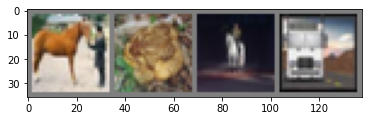

horse frog  horse truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
class CNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_layer_1 = nn.Conv2d(3, 12, 3)
    self.cnn_layer_2 = nn.Conv2d(12, 6, 3)
    self.pool_layer = nn.MaxPool2d(2)
    self.dense_layer_1 = nn.Linear(6 * 6 * 6, 120)
    self.dense_layer_2 = nn.Linear(120, 84)
    self.dense_layer_3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool_layer(F.relu(self.cnn_layer_1(x)))
    x = self.pool_layer(F.relu(self.cnn_layer_2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.dense_layer_1(x))
    x = F.relu(self.dense_layer_2(x))
    x = self.dense_layer_3(x)
    # x = torch.nn.functional.softmax(self.dense_layer_1(x))
    return x

net = CNNClassifier()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.262
[1,  4000] loss: 1.239
[1,  6000] loss: 1.244
[1,  8000] loss: 1.228
[1, 10000] loss: 1.214
[1, 12000] loss: 1.219
[2,  2000] loss: 1.164
[2,  4000] loss: 1.155
[2,  6000] loss: 1.149
[2,  8000] loss: 1.150
[2, 10000] loss: 1.157
[2, 12000] loss: 1.124
Finished Training


In [25]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

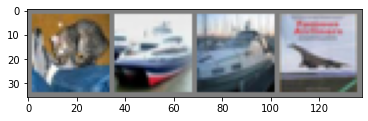

GroundTruth:  cat   ship  ship  plane


In [26]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
net = CNNClassifier()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [32]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
print(outputs)

Predicted:  cat   dog   car   horse
tensor([[-2.7670, -2.5082,  0.6531,  3.4584,  1.9561,  3.0553,  3.2252, -0.4748,
         -3.3529, -4.0595],
        [-2.2978, -3.9208,  4.7224,  0.9805, -2.6581,  5.2285, -0.3007,  1.2312,
         -3.4808, -2.4811],
        [-0.7269,  3.5081, -0.1633,  0.5046,  1.3553, -0.5456, -0.2113, -0.5225,
         -2.2207, -1.9742],
        [-2.9427, -3.6448,  1.1117,  0.9444,  3.0536,  1.0510,  1.8805,  5.6605,
         -6.0606, -3.1544]], grad_fn=<AddmmBackward0>)


In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.5 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 43.9 %
Accuracy for class: cat   is 32.8 %
Accuracy for class: deer  is 31.7 %
Accuracy for class: dog   is 57.9 %
Accuracy for class: frog  is 85.6 %
Accuracy for class: horse is 60.0 %
Accuracy for class: ship  is 76.7 %
Accuracy for class: truck is 61.1 %


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [9]:
net.to(device)

CNNClassifier(
  (cnn_layer_1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (cnn_layer_2): Conv2d(12, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense_layer_1): Linear(in_features=216, out_features=120, bias=True)
  (dense_layer_2): Linear(in_features=120, out_features=84, bias=True)
  (dense_layer_3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
inputs, labels = next(iter(trainloader))[0].to(device), next(iter(trainloader))[1].to(device)
# inputs, labels = testloader[0].to(device), testloader[1].to(device)

In [16]:
type(inputs)

torch.Tensor

In [17]:
type(next(iter(trainloader))[0])

torch.Tensor